In [1]:
import gc, math, pickle, datetime, os, random
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot,dates

import warnings
warnings.filterwarnings('ignore')
import gc

In [2]:
train=pd.read_csv('C:/Users/Pink/Desktop/Advance America/train.csv')
test=pd.read_csv('C:/Users/Pink/Desktop/Advance America/test.csv')

In [3]:
print('Shape of Train',train.shape)
print('Shape of Test',test.shape)

Shape of Train (20839, 13)
Shape of Test (1000, 12)


In [4]:
print('Unique counts\n',train['target'].value_counts())
print('percentage with target 0 -',train['target'].value_counts()[0]/len(train))
print('percentage with target 1 -',train['target'].value_counts()[1]/len(train))

Unique counts
 0    18710
1     2129
Name: target, dtype: int64
percentage with target 0 - 0.897835788665483
percentage with target 1 - 0.10216421133451702


In [5]:
## 8760 -- 365*24
import datetime as dt
print('Creating Current Age variable')
train['date_of_birth']=pd.to_datetime(train["date_of_birth"])
train['Age']=((dt.datetime.now() - train['date_of_birth']).astype('timedelta64[h]')/8760).apply(lambda x:np.floor(x))

print('for test')
test['date_of_birth']=pd.to_datetime(test["date_of_birth"])
test['Age']=((dt.datetime.now() - test['date_of_birth']).astype('timedelta64[h]')/8760).apply(lambda x:np.floor(x))

Creating Current Age variable
for test


In [6]:
print('Creating Unique Features for test and train')
print('---------------------------------------')
train['MI_num_opncrdlns_interact']=train['monthly_income']*train['number_open_credit_lines']
train['score1_score2_interaction'] = ((train['score2']*train['score1']))
train['credit_remain_after_debt'] =train.monthly_income - (train.debt_to_income_ratio*train.monthly_income)
train['scr1_monthly_income_interact']=((train['score1']*train['monthly_income']))
train['scr2_monthly_income_interact']=((train['score2']*train['monthly_income']))
train['score1_score2_monthyInceome_interact']=train['score1']*train['score2']*train['monthly_income']
train['Age_monthly_income']=train['monthly_income']/train['Age']
train['monthly_remains']=train['monthly_income']/(10**-9+train['number_open_credit_lines'] + train['number_open_loans'] + train['number_dependants'])
train['monthly_remains']=train['monthly_income']-train['monthly_remains']
print('---------------------------------------')
test['MI_num_opncrdlns_interact']=test['monthly_income']*test['number_open_credit_lines']
test['score1_score2_interaction'] = ((test['score2']*test['score1']))
test['credit_remain_after_debt'] =test.monthly_income - (test.debt_to_income_ratio*test.monthly_income)
test['scr1_monthly_income_interact']=((test['score1']*test['monthly_income']))
test['scr2_monthly_income_interact']=((test['score2']*test['monthly_income']))
test['score1_score2_monthyInceome_interact']=test['score1']*test['score2']*test['monthly_income']

#train['score2_score2'] = train['score2']*train['score2']
#train['monthly_income_monthly_income'] = train['monthly_income']*train['monthly_income']

test['Age_monthly_income']=test['monthly_income']/train['Age']

test['monthly_remains']=test['monthly_income']/(10**-9+test['number_open_credit_lines'] + test['number_open_loans'] + test['number_dependants'])
test['monthly_remains']=test['monthly_income']-test['monthly_remains']

test['bin_monthly_income']=pd.cut(test['monthly_income'],bins = np.linspace(np.min(test['monthly_income'])-100, np.max(test['monthly_income']), num = 15))

Creating Unique Features for test and train
---------------------------------------
---------------------------------------


In [7]:
print('Create Binnning of Monthly Income train and Test')
train['bin_monthly_income']=pd.cut(train['monthly_income'],bins = np.linspace(np.min(train['monthly_income'])-100, np.max(train['monthly_income']), num = 15))
test['bin_monthly_income']=pd.cut(test['monthly_income'],bins = np.linspace(np.min(test['monthly_income'])-100, np.max(test['monthly_income']), num = 15))

Create Binnning of Monthly Income train and Test


In [8]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
train['bin_monthly_income']= label_encoder.fit_transform(train['bin_monthly_income'])
test['bin_monthly_income']= label_encoder.fit_transform(test['bin_monthly_income'])

In [9]:
print('Find-nan train:',train.isnull().sum().any())
print('Find-nan test:',test.isnull().sum().any())

Find-nan train: False
Find-nan test: False


In [10]:
print('Train')
Y=train['target']
X=train.drop(['id','date_of_birth','target'],axis=1)
print('X',X.shape,'Y',Y.shape)

print('Test')
test=test.drop(['id','date_of_birth'],axis=1)

print('Number of columns in train and test should be same','test',test.shape[1],'X-Train',X.shape[1])

Train
X (20839, 20) Y (20839,)
Test
Number of columns in train and test should be same test 20 X-Train 20


In [11]:
from sklearn.preprocessing import RobustScaler
# Scaling..
scaler = RobustScaler()
X = scaler.fit_transform(X)
test = scaler.fit_transform(test)

#### Hyper parameter tuning of LightGBM

In [12]:
from hyperopt import STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        #'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }
    
    clf = lgb.LGBMClassifier(scale_pos_weight =(18710/2129),min_data_in_leaf=80,class_weight='balanced',n_estimators=500,**params)
    
    score = cross_val_score(clf, X, Y, scoring='roc_auc', cv=StratifiedKFold()).mean()
    print("roc_auc {:.3f} params {}".format(score, params))
    return score

In [13]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space = {

    'max_depth': hp.quniform('max_depth', 7, 23, 1),

    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),

    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),

    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),

    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),

    'gamma': hp.uniform('gamma', 0.01, .7),

   # 'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),

    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),

    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),

    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),

    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)

}

In [14]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

roc_auc 0.724 params {'max_depth': 14, 'gamma': '0.498', 'subsample': '0.60', 'reg_alpha': '0.098', 'reg_lambda': '0.363', 'learning_rate': '0.171', 'colsample_bytree': '0.536', 'min_child_samples': '180.000', 'feature_fraction': '0.469', 'bagging_fraction': '0.491'}
roc_auc 0.729 params {'max_depth': 20, 'gamma': '0.020', 'subsample': '0.20', 'reg_alpha': '0.305', 'reg_lambda': '0.162', 'learning_rate': '0.147', 'colsample_bytree': '0.746', 'min_child_samples': '140.000', 'feature_fraction': '0.543', 'bagging_fraction': '0.583'}
roc_auc 0.723 params {'max_depth': 10, 'gamma': '0.404', 'subsample': '0.40', 'reg_alpha': '0.316', 'reg_lambda': '0.178', 'learning_rate': '0.180', 'colsample_bytree': '0.719', 'min_child_samples': '200.000', 'feature_fraction': '0.697', 'bagging_fraction': '0.621'}
roc_auc 0.766 params {'max_depth': 8, 'gamma': '0.456', 'subsample': '0.70', 'reg_alpha': '0.254', 'reg_lambda': '0.199', 'learning_rate': '0.011', 'colsample_bytree': '0.427', 'min_child_samples'

In [15]:
print("Hyperopt estimated optimum {}".format(best))
best['max_depth'] = int(best['max_depth'])

Hyperopt estimated optimum {'bagging_fraction': 0.45254862303110904, 'colsample_bytree': 0.7984066186401673, 'feature_fraction': 0.6363231189182963, 'gamma': 0.5835222950636281, 'learning_rate': 0.19828196191779748, 'max_depth': 12.0, 'min_child_samples': 14, 'reg_alpha': 0.13969256712430847, 'reg_lambda': 0.12897453117675745, 'subsample': 1}


In [16]:
columns=train.drop(['id','date_of_birth','target'],axis=1).columns


In [24]:
lgb_params = {'bagging_fraction': 0.45254862303110904, 
              'colsample_bytree': 0.7930996128401728, 
              'feature_fraction': 0.6363231189182963, 
              'gamma': 0.5835222950636281, 
              'learning_rate': 0.1999421721926211, 
              'max_depth': 12, 
              'min_child_samples': 14, 
              'reg_alpha': 2.5, 
              'reg_lambda': 2.5, 
              'subsample': 0,
              'scale_pos_weight' :(18710/2129),
              'min_data_in_leaf':80,
              'class_weight' :'balanced',
                'objective' :'binary',
                'boosting' : "gbdt",
                'metric':"auc",
                'boost_from_average':False
             }

In [39]:
lgb_params = {
    'objective' :'binary',
    'boosting' : "gbdt",
    'metric':"auc",
    'boost_from_average':False,
    'num_threads':8,
    'learning_rate' :.005,
    'num_leaves' :13,
    'max_depth':-1,
    'feature_fraction' :0.041,
    'bagging_freq' :5,
    'bagging_fraction' :0.331,
    'min_data_in_leaf' :80,
    'min_sum_hessian_in_leaf' :10.0,
    'verbosity' :1,
    'num_iterations' :99999999,
    'seed': 44000,
    'scale_pos_weight' :(18710/2129)-1,
    'reg_lambda': 5,
    'reg_alpha': 5,
    'min_child_weight': 0.1,
    'max_bin': 150
           }

In [40]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns


splits = folds.split(X,Y)
y_preds = np.zeros(test.shape[0])
y_oof_lgb = np.zeros(X.shape[0])
score = 0

for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = Y[train_index], Y[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    ## feature Importance
    clf = lgb.train(lgb_params, dtrain, 600, valid_sets = [dtrain, dvalid], verbose_eval=200,early_stopping_rounds=500)
    y_preds += clf.predict(test) / NFOLDS
    

    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof_lgb[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    

    
    score += roc_auc_score(y_valid, y_pred_valid)/ NFOLDS
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(Y, y_oof_lgb)}")


Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.782052	valid_1's auc: 0.744393
[400]	training's auc: 0.786354	valid_1's auc: 0.749311
[600]	training's auc: 0.790684	valid_1's auc: 0.751619
[800]	training's auc: 0.794688	valid_1's auc: 0.754153
[1000]	training's auc: 0.798375	valid_1's auc: 0.755493
[1200]	training's auc: 0.802027	valid_1's auc: 0.756466
[1400]	training's auc: 0.805235	valid_1's auc: 0.756841
[1600]	training's auc: 0.808501	valid_1's auc: 0.7574
[1800]	training's auc: 0.811634	valid_1's auc: 0.757357
[2000]	training's auc: 0.814749	valid_1's auc: 0.757603
[2200]	training's auc: 0.817224	valid_1's auc: 0.757214
[2400]	training's auc: 0.819885	valid_1's auc: 0.756903
Early stopping, best iteration is:
[1930]	training's auc: 0.813804	valid_1's auc: 0.757709
Fold 1 | AUC: 0.7577087755689085
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.77782	valid_1's auc: 0.762037
[400]	training's auc: 0.782565	v

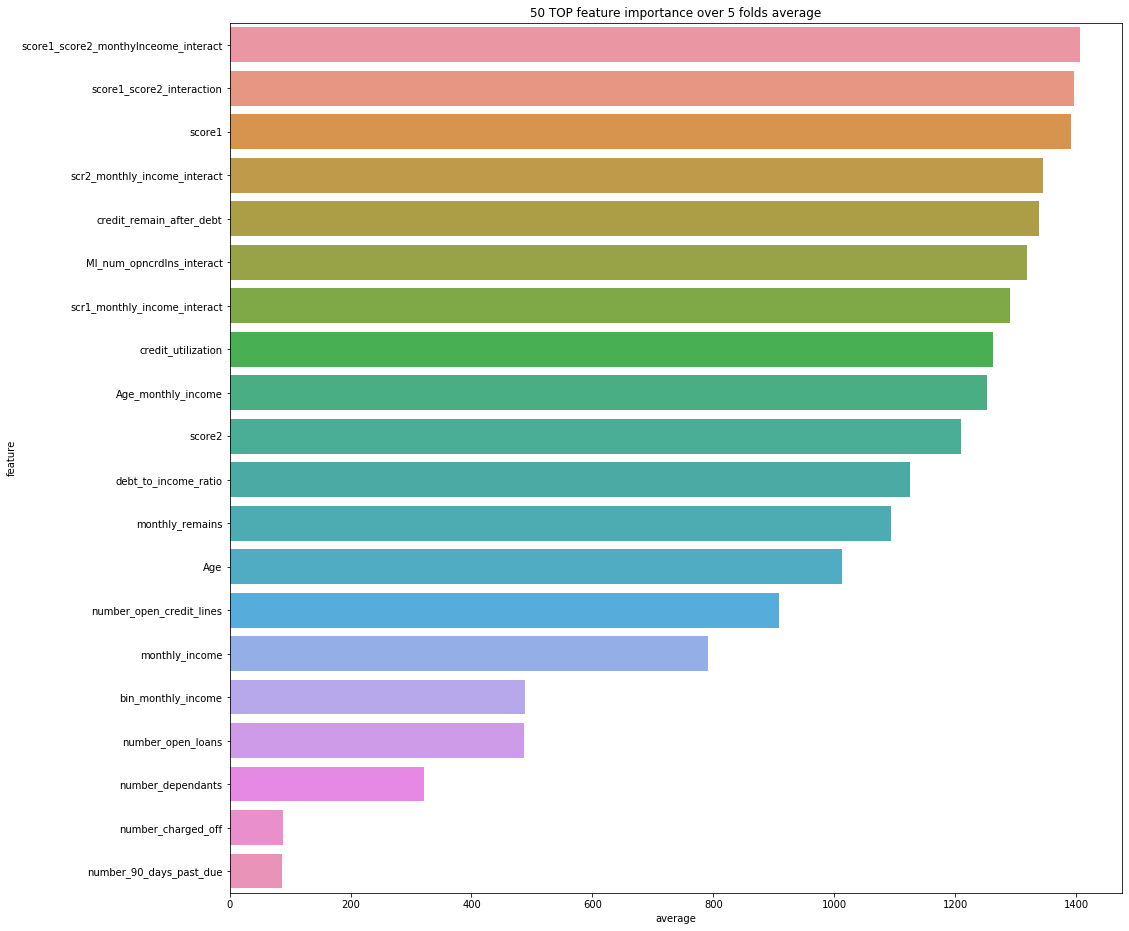

In [41]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [42]:
Y_test=np.zeros(y_preds.shape[0])
for i in range(len(y_preds)):
    if y_preds[i]>=.55:
        Y_test[i]=1
    else:
        Y_test[i]=0

In [43]:
unique_elements, counts_elements = np.unique(Y_test, return_counts=True)
counts_elements

array([760, 240], dtype=int64)